## CV pet-project: Insulators defects, Кривоногов Николай


Задача: обучение модели классификации дефектов электрических изоляторов. 

Три типа дефектов: Скол, трещина, грязь. Дефекты не взаимоисключающие. Изолятор может быть одновременно и со сколом и грязью или со всеми тремя дефектами. 

В датасете их присутствие кодируется последними тремя цифрами в имени изображения. К примеру 15_3_100.jpg. 
100 это метки дефектов. Первая цифра скол (он тут есть), вторая цифра грязь (ее нет), третья трещина (ее нет). 

Написан полный код обучения и валидации на pytorch. В качестве метрики использовалась F1 (отдельно для каждого класса и общая). Проводится логирование метрик и лосса, используется tensorboard. 

Датасет несбалансированный по количеству классов. Поэтому предложено решение, как иметь с этим дело. 

Данные для запуска ноутбука: 

https://drive.google.com/file/d/16A8y2Z5SEhkDSVesIAc5uoWQ-DRjOo7Q/view?usp=sharing

In [1]:
# импорт необходимых библиотек:
import os, glob, shutil, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset

from torchvision.utils import save_image

import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import f1_score, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
from skimage import io

In [3]:
# указываю путь к файлам:
path = 'insulators/'

# создаю пустой список с именами файлов:
list_of_files = []

# прохожу по файлам, добавляя в список их имена:
for file in os.listdir(path):
    list_of_files.append(file)

# создаю датафрейм с именами файлов:
df = pd.DataFrame(list_of_files, columns = ['filename'])

df

,filename
0,10006_12_000.jpg
1,10006_1_000.jpg
2,100087_2_100.jpg
3,10010_4_000.jpg
4,100235_3_001.jpg
...,...
5995,99502_1_100.jpg
5996,9955_1_000.jpg
5997,99607_13_000.jpg
5998,99607_1_000.jpg


In [4]:
# создаю столбец с лейблом класса:
df['class'] = df['filename'].apply(lambda x: x.split('_')[2].split('.')[0])

df

,filename,class
0,10006_12_000.jpg,000
1,10006_1_000.jpg,000
2,100087_2_100.jpg,100
3,10010_4_000.jpg,000
4,100235_3_001.jpg,001
...,...,...
5995,99502_1_100.jpg,100
5996,9955_1_000.jpg,000
5997,99607_13_000.jpg,000
5998,99607_1_000.jpg,000


In [5]:
# смотрю соотношение классов:
df['class'].value_counts()

000    2186
010    2008
100    1226
001     545
110      22
101       8
011       5
Name: class, dtype: int64

2186 картинок с хорошими изоляторами

2008 с грязью

1226 со сколом

545 с трещиной

22 со сколом и грязью

8 со сколом и трещиной

5 с грязью и трещиной

_____________________________________
картинки изоляторов и со сколом, и с грязью, и с трещиной отсутствуют 

_____________________________________
имею 7 классов (с сильным дисбалансом)

In [6]:
# раскладываю файлы с одинаковым классом по соответствующим названным папкам:
for file_path in glob.glob(os.path.join(path, '*.*')):
    new_dir = file_path.split('_')[2].split('.')[0]
    try:
        os.mkdir(os.path.join(path, new_dir))
    except WindowsError:
        # когда папка уже существует:
        pass
    shutil.copy(file_path, os.path.join(path, new_dir))

Получаю среднее и стандартное отклонение для последующей нормализации данных с целью улучшения качества модели: 

In [7]:
training_dataset_path = './insulators'

In [8]:
training_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [9]:
train_dataset = torchvision.datasets.ImageFolder(root = training_dataset_path, transform = training_transforms)

In [10]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=32, shuffle=False)

In [11]:
# функция для рассчета среднего и стандартного отклонения: 
def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
        
    mean /= total_images_count
    std /= total_images_count
    
    return mean, std

In [12]:
get_mean_and_std(train_loader)

(tensor([0.5100, 0.5429, 0.5238]), tensor([0.2113, 0.2122, 0.2167]))

Устранение дисбаланса: 

In [13]:
# создаю класс для формирования кастомного датасета для аугментации и "размножения": 
class ImbInsDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.annotations = df
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
        
        return (image, y_label)

In [14]:
# получаю среднее и отклонение для нормализации, использую методы аугментации: 
mean, std = get_mean_and_std(train_loader)

imb_transforms = transforms.Compose([
    transforms.ToPILImage(), # перевод в формат PIL
    transforms.Resize((224, 224)), # изменение размера
    transforms.ColorJitter(), # произвольное изменение яркости, контрастности, насыщенности и оттенка
    transforms.RandomRotation(10), # случайный поворот
    transforms.RandomHorizontalFlip(), # случайное горизонтальное отображение
    transforms.ToTensor(), # перевод в тензор
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)) # нормализация
])

In [15]:
# указываю путь к файлам: 
path = './images/training/011'

# создаю пустой список с именами файлов: 
list_of_files = []

# прохожу по файлам, добавляя в список их имена: 
for file in os.listdir(path):
    list_of_files.append(file)

# создаю датафрейм с именами файлов: 
df = pd.DataFrame(list_of_files, columns = ['filename'])

df

,filename
0,132040_0_011.jpg
1,14916_4_011.jpg
2,1578_0_011.jpg
3,1745_1_011.jpg


In [16]:
# создаю столбец с лейблом класса: 
df['class'] = df['filename'].apply(lambda x: x.split('_')[2].split('.')[0])

df

,filename,class
0,132040_0_011.jpg,011
1,14916_4_011.jpg,011
2,1578_0_011.jpg,011
3,1745_1_011.jpg,011


In [17]:
# создаю кастомный датасет для применения аугментации и "размножения" картинок: 
imb_dataset = ImbInsDataset(df = df, root_dir = path, transform = imb_transforms)

In [18]:
# "размножение" картинок: 
img_num = 0

for _ in range(100):
    for img, label in imb_dataset:
        save_image(img, './images/training/011/imb_img'+'_'+str(label)+'_'+str(img_num)+'.jpg')
        img_num += 1

In [19]:
# аналогично для класса 101:
path = './images/training/101'

list_of_files = []

for file in os.listdir(path):
    list_of_files.append(file)

df = pd.DataFrame(list_of_files, columns = ['filename'])

df['class'] = df['filename'].apply(lambda x: x.split('_')[2].split('.')[0])

imb_dataset = ImbInsDataset(df = df, root_dir = path, transform = imb_transforms)

img_num = 0

for _ in range(100):
    for img, label in imb_dataset:
        save_image(img, './images/training/101/imb_img'+'_'+str(label)+'_'+str(img_num)+'.jpg')
        img_num += 1

In [20]:
# аналогично для класса 110:
path = './images/training/110'

list_of_files = []

for file in os.listdir(path):
    list_of_files.append(file)

df = pd.DataFrame(list_of_files, columns = ['filename'])

df['class'] = df['filename'].apply(lambda x: x.split('_')[2].split('.')[0])

imb_dataset = ImbInsDataset(df = df, root_dir = path, transform = imb_transforms)

img_num = 0

for _ in range(100):
    for img, label in imb_dataset:
        save_image(img, './images/training/110/imb_img'+'_'+str(label)+'_'+str(img_num)+'.jpg')
        img_num += 1

Теперь классы более сбалансированы. 

In [21]:
# пути к датасетам:
train_dataset_path = './images/training'
test_dataset_path = './images/validation'

In [22]:
#mean, std = get_mean_and_std(train_loader)

mean = [0.5100, 0.5429, 0.5238]
std = [0.2113, 0.2122, 0.2167]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [23]:
# определяю датасеты: 
train_dataset = torchvision.datasets.ImageFolder(root = train_dataset_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_dataset_path, transform = test_transforms)

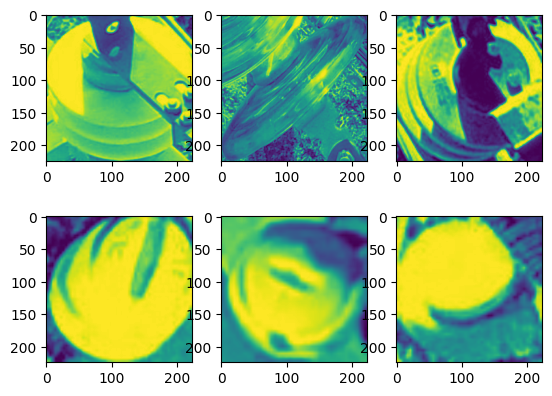

In [24]:
# посмотрю 6 картинок из обучающей выборки:
dataiter = iter(train_loader)
images, labels = next(dataiter)

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i][0])

img_grid = torchvision.utils.make_grid(images)

In [25]:
# добавляю картинки на tensorboard: 
writer = SummaryWriter('runs/ins_def')

writer.add_image('Butsh-sized number of insulators images', img_grid)
writer.flush()

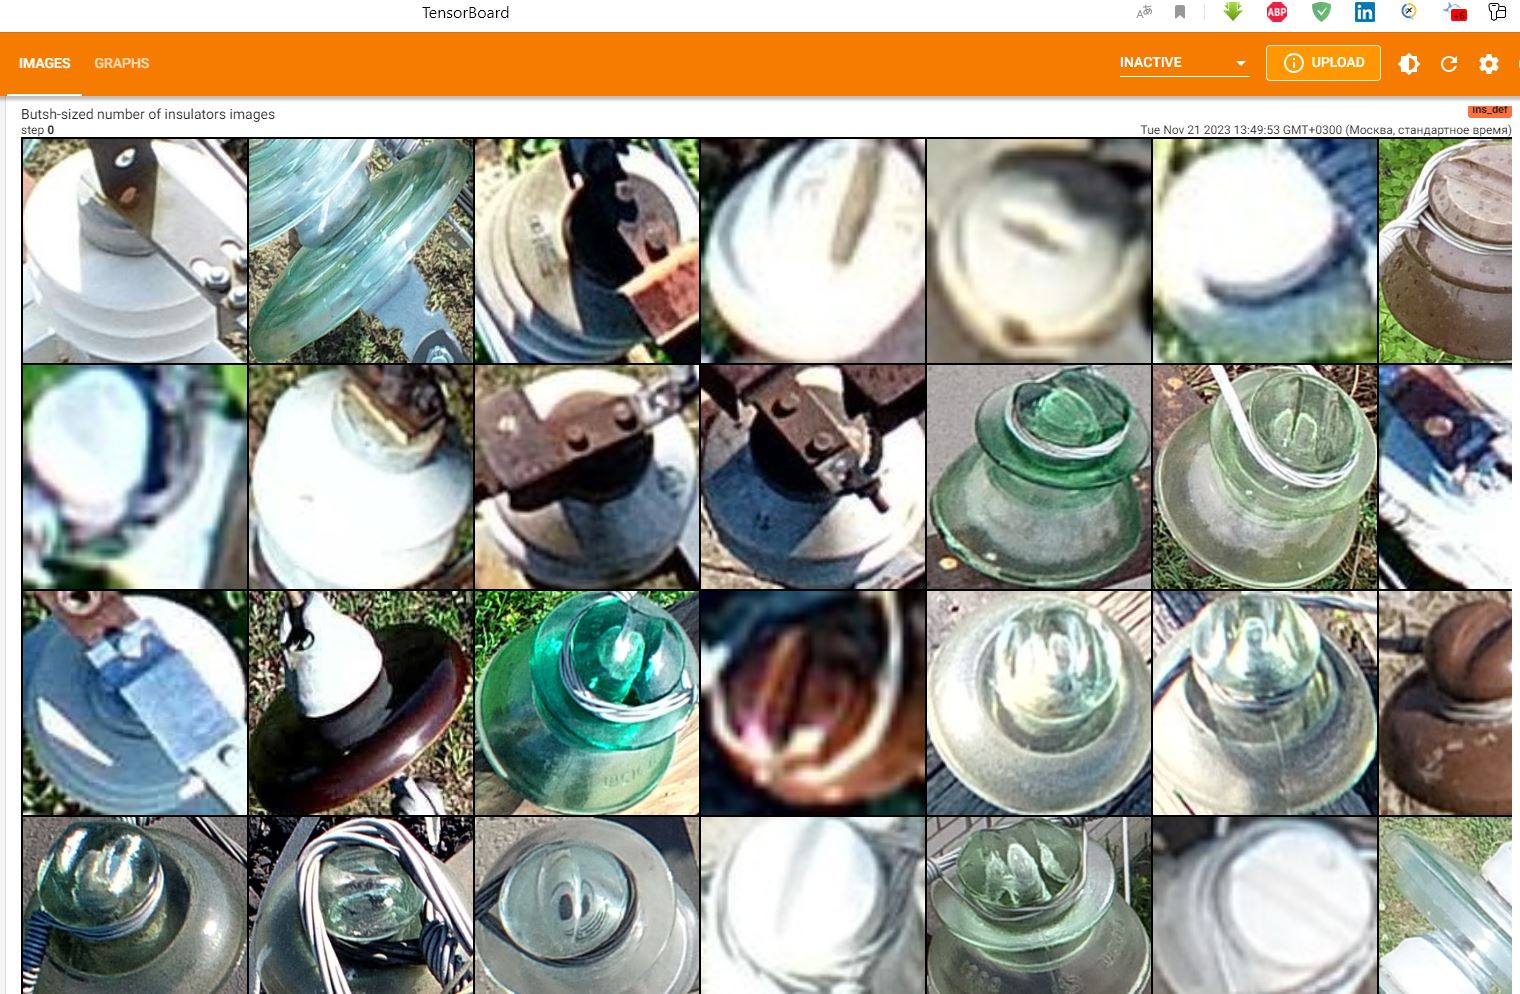

In [26]:
# определяю даталоадеры:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [27]:
# функция для определения типа CUDA:
def set_device():
    if torch.cuda.is_available():
        dev = 'cuda:0'
    else:
        dev = 'cpu'
    return torch.device(dev)

In [28]:
# функция для обучения нейронной сети и логирования:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    best_f1 = 0
    
    for epoch in range(n_epochs):
        print('Epoch number %d : ' % (epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0
        
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()
            
        train_loss = running_loss / len(train_loader)
        train_acc = running_correct / total
        
        print('     - Training dataset. Got %d out of %d images correctly (accuracy %.3f). Loss: %.3f'
              % (running_correct, total, train_acc, train_loss))
        
        test_dataset_f1, test_loss, test_acc = evaluate_model_on_test_set(model, test_loader, criterion)

        # добавляю графики на tensorboard: 
        writer.add_scalars('Training vs. Validation Loss', 
                         {'Training': train_loss,
                          'Validation': test_loss},
                          epoch)
        writer.add_scalars('Training vs. Validation Accuracy', 
                         {'Training': train_acc,
                          'Validation': test_acc},
                          epoch)
        writer.add_scalar('F1 common', test_dataset_f1, epoch)        
        
        if (test_dataset_f1 > best_f1):
            best_f1 = test_dataset_f1
            save_checkpoint(model, epoch, optimizer, best_f1)
        
    print('FINISHED')
    
    return model

writer.flush()

In [29]:
# функция для валидации нейронной сети и логирования: 
def evaluate_model_on_test_set(model, test_loader, criterion):
    model.eval()
    val_loss = 0
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            
            predicted_correctly_on_epoch += (predicted==labels).sum().item()
            
        test_loss = val_loss / len(test_loader)
        test_acc = predicted_correctly_on_epoch / total

        f1_each = f1_score(y_true=labels, y_pred=predicted, average=None, zero_division=1)
        f1_weighted = round(f1_score(y_true=labels, y_pred=predicted, average='weighted', zero_division=1), 3)
        
        print('     - Validation dataset. Got %d out of %d images correctly (accuracy %.3f). Loss: %.3f\n'
             % (predicted_correctly_on_epoch, total, test_acc, test_loss), '\nF1 for each class: ', f1_each, '\nF1 common: ', f1_weighted, '\n')
    
    print(classification_report(y_true=labels, y_pred=predicted))
    
    return f1_weighted, test_loss, test_acc

In [30]:
# функция сохранения контрольной точки: 
def save_checkpoint(model, epoch, optimizer, best_f1):
    state = {
        'model': model.state_dict(),
        'epoch': epoch + 1,
        'optimizer': optimizer.state_dict(),
        'best f1': best_f1
    }
    torch.save(state, 'model_best_checkpoint.pth.tar')

In [31]:
# использую относительно небольшую предобученную нейронную сеть RESNET18:
resnet18_model = models.resnet18(weights=True) # традиционный параметр pretrained изменился на weights

num_ftrs = resnet18_model.fc.in_features
number_of_classes = 7
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet18_model = resnet18_model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

In [32]:
# добавляю мобель на tensorboard: 
dataiter = iter(train_loader)
images, labels = next(dataiter)

writer.add_graph(resnet18_model, images)
writer.flush()

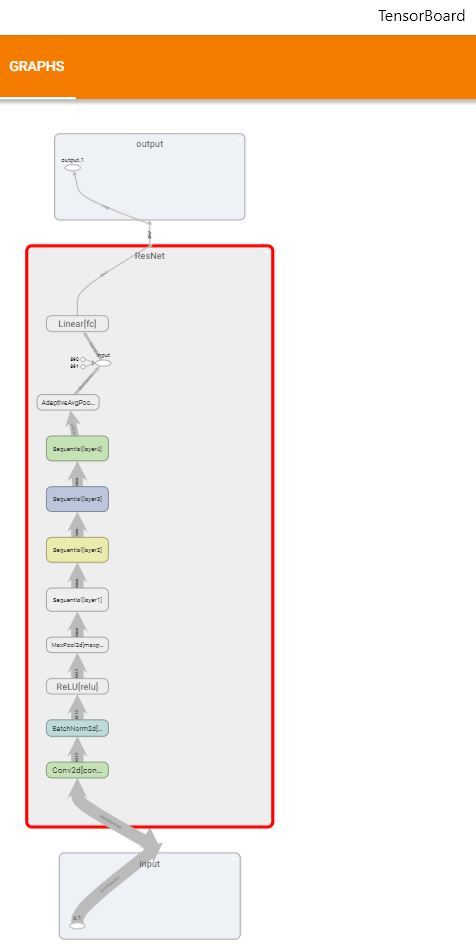

In [33]:
# запуск обучения модели с логированием:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 50)

Epoch number 1 : 
     - Training dataset. Got 4253 out of 7600 images correctly (accuracy 0.560). Loss: 1.149
     - Validation dataset. Got 615 out of 1200 images correctly (accuracy 0.512). Loss: 1.145
 
F1 for each class:  [0.         0.         0.53968254 0.         0.        ] 
F1 common:  0.472 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           4       0.81      0.40      0.54        42
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         4

    accuracy                           0.35        48
   macro avg       0.16      0.08      0.11        48
weighted avg       0.71      0.35      0.47        48

Epoch number 2 : 
     - Training dataset. Got 5416 out of 7600 images correctly (accuracy 0.713). Loss: 0.703
     - Validation dataset. Got 676 out of 1200 images correctly (accuracy 0.563). Loss: 1.078
 

     - Training dataset. Got 6219 out of 7600 images correctly (accuracy 0.818). Loss: 0.463
     - Validation dataset. Got 751 out of 1200 images correctly (accuracy 0.626). Loss: 1.012
 
F1 for each class:  [0.         0.         0.         0.50847458 0.         0.        ] 
F1 common:  0.445 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           4       0.88      0.36      0.51        42
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         4

    accuracy                           0.31        48
   macro avg       0.15      0.06      0.08        48
weighted avg       0.77      0.31      0.44        48

Epoch number 12 : 
     - Training dataset. Got 6309 out of 7600 images correctly (accuracy 0.830). Loss: 0.444
     - Validation dataset. Got 760 out of 1200 

     - Training dataset. Got 6927 out of 7600 images correctly (accuracy 0.911). Loss: 0.262
     - Validation dataset. Got 765 out of 1200 images correctly (accuracy 0.637). Loss: 1.108
 
F1 for each class:  [0.         0.         0.         0.71641791 0.         0.        ] 
F1 common:  0.627 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           4       0.96      0.57      0.72        42
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         4

    accuracy                           0.50        48
   macro avg       0.16      0.10      0.12        48
weighted avg       0.84      0.50      0.63        48

Epoch number 22 : 
     - Training dataset. Got 6998 out of 7600 images correctly (accuracy 0.921). Loss: 0.237
     - Validation dataset. Got 762 out of 1200 

     - Training dataset. Got 7379 out of 7600 images correctly (accuracy 0.971). Loss: 0.105
     - Validation dataset. Got 768 out of 1200 images correctly (accuracy 0.640). Loss: 1.421
 
F1 for each class:  [0.         0.         0.         0.54237288 0.         0.        ] 
F1 common:  0.475 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           4       0.94      0.38      0.54        42
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         4

    accuracy                           0.33        48
   macro avg       0.16      0.06      0.09        48
weighted avg       0.82      0.33      0.47        48

Epoch number 32 : 
     - Training dataset. Got 7428 out of 7600 images correctly (accuracy 0.977). Loss: 0.090
     - Validation dataset. Got 768 out of 1200 

     - Training dataset. Got 7551 out of 7600 images correctly (accuracy 0.994). Loss: 0.040
     - Validation dataset. Got 767 out of 1200 images correctly (accuracy 0.639). Loss: 1.574
 
F1 for each class:  [0.      0.      0.      0.65625 0.      0.     ] 
F1 common:  0.574 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           4       0.95      0.50      0.66        42
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         4

    accuracy                           0.44        48
   macro avg       0.16      0.08      0.11        48
weighted avg       0.84      0.44      0.57        48

Epoch number 42 : 
     - Training dataset. Got 7541 out of 7600 images correctly (accuracy 0.992). Loss: 0.037
     - Validation dataset. Got 765 out of 1200 images correctly (

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

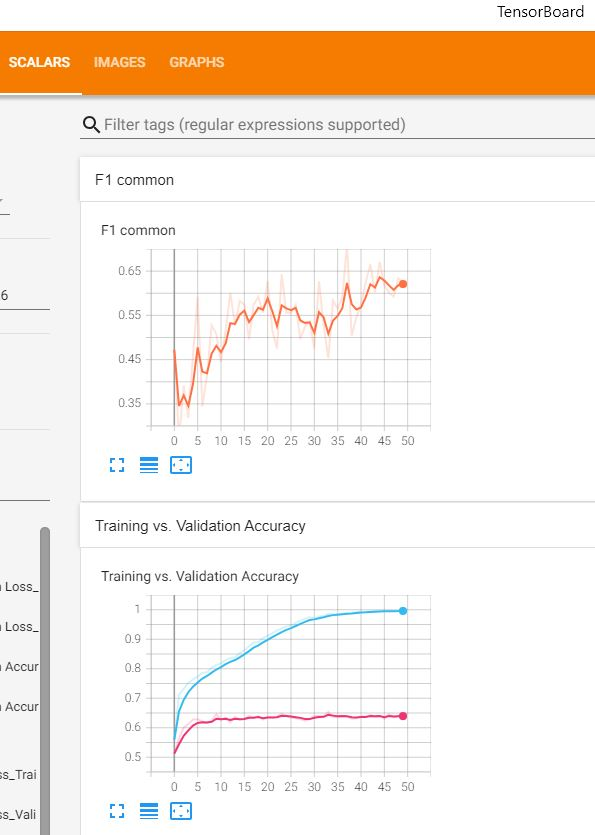

In [34]:
# загрузка лучшей контрольной точки:
checkpoint = torch.load('model_best_checkpoint.pth.tar')

In [35]:
# просмотр ее параметров: 
print(checkpoint['epoch'])
print(checkpoint['best f1'])

38
0.709


In [36]:
# сохранение лучшей модели: 
resnet18_model = models.resnet18()
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 7
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
resnet18_model.load_state_dict(checkpoint['model'])

torch.save(resnet18_model, 'best_model.pth')